# Nuclear Game - Analysis
Gabriel Emilio Herrera Oropeza <br>
13/06/2022

In [43]:
import ngtools.analyzer as ngt
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import pandas as pd
from tqdm import tqdm
import scanpy as sc
import numpy as np

## Data Processing
### Import data

In [5]:
path_to_experiments = "../data"
data = ngt.import_ng_data(path_to_experiments)

### Center DAPI

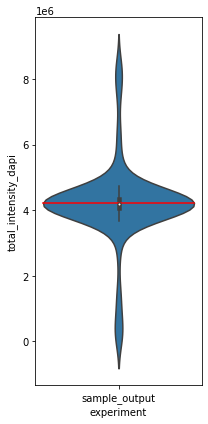

In [6]:
data = ngt.centerDAPI(data, splitBy = "experiment", nbins = 100, showPlot = True)

### Identify Single Cells
Identify single cells based on DNA marker content.

In [8]:
scData = ngt.find_SingleCells(data, byExperiment = True, nbins = 100, spread = 0.4, channel = "dapi", hue = "experiment")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.81it/s]


Check selection of single cells:

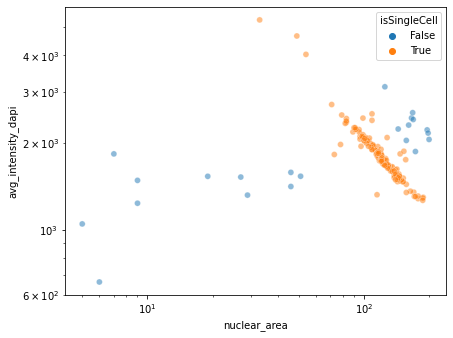

In [13]:
fig, ax = plt.subplots(figsize = (6.4, 4.8))
ax = sns.scatterplot(data = scData, y = "avg_intensity_dapi", x = "nuclear_area", hue = "isSingleCell", alpha = 0.5,
                    ax = ax)
ax.set(xscale = "log"); ax.set(yscale = "log"); plt.tight_layout()
plt.show()

In [14]:
# Keep only single cells
scData = scData[scData["isSingleCell"] == True].copy()

### Intensity Normalisation
Statistic-based normalisation of intensity data. **Options are: mode, mean, and median.** *nbins* is used only when method is *mode*. DAPI channel is not normalised.

In [15]:
normData, normMetadata = ngt.intensityNormalisation(scData, method = "mode", nbins = 100, verbose = False, 
                                                hue = "experiment")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 61.15it/s]


Observe data before normalisation for a channel. The red line represents the statistical method value used for normalisation.

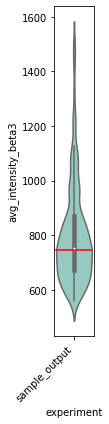

In [16]:
channel = "beta3" # Modify channel as needed
log_scale = False # Modify to True or False as needed

fig, ax = plt.subplots(figsize = (len(normMetadata)*1.5, 6))

x = "experiment"
y = f"avg_intensity_{channel}"
data_to_plot = scData[[x, y]].copy()

if log_scale:
    data_to_plot[y] = [log10(l) for l in data_to_plot[y]]
    
ax = sns.violinplot(x = x, y = y, data = data_to_plot, palette = "Set3", bw = .2, order = list(normMetadata.keys()),
                    ax = ax)
    
plt.xticks(rotation = 45,ha = "right")

for n, exp in enumerate(normMetadata):
    Y = log10(normMetadata[exp][y]) if log_scale else normMetadata[exp][y]
    X = n
    plt.plot([X-0.4,X+0.4], [Y,Y], color='r')

if log_scale:
    plt.ylabel(f"{y} (log10)")
plt.tight_layout()
#fig.savefig(f"J:/emilio/figures/laminAC/{channel}_normalisation.pdf")
plt.show()

## Data Exploration

### Linear relationships

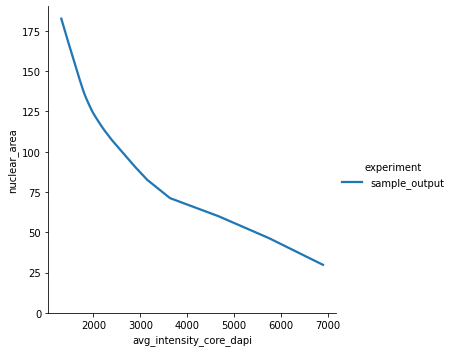

In [17]:
x = "avg_intensity_core_dapi" # Change as needed
y = "nuclear_area" # Change as needed

fig = sns.lmplot(x = x, 
                 y = y, 
                 data = normData,
                 hue = "experiment",
                 lowess = True,
                 scatter = False
                )
#plt.xlim(10,)
plt.ylim(0,)
plt.show()

### Dimension Reduction

In [18]:
wkData = normData.copy()

In [19]:
# List of observations
obs_ = ['imageID', 
        'experiment', 
        'cellID',
        "x_pos", 
        "y_pos",
        "angle",
        "ngn_class",
        "rfp_class",
        "laminB1_class",
        'avg_intensity_ngn',
        'path2ong',
       ]

In [20]:
# List of features
data_cols = [
'avg_intensity_dapi',
'nuclear_area',
'nuclear_perimeter',
'major_axis',
'minor_axis',
'axes_ratio',
'circularity',
'eccentricity',
'solidity',
'avg_intensity_core_dapi',
'avg_intensity_internal_ring_dapi',
'avg_intensity_external_ring_dapi',
#'total_intensity_core_dapi',
#'total_intensity_internal_ring_dapi',
#'total_intensity_external_ring_dapi',
#'total_intensity_dapi',
#'total_intensity_gfap',
'avg_intensity_rfp',
#'total_intensity_rfp',
'avg_intensity_ngn',
#'total_intensity_beta3',
#'dna_peaks',
'dna_dots',
'dna_dots_size_median',
'spatial_entropy',
#'total_intensity_olig2',
#'gfap_positive',
#'gfap_frac_covered',
#'rfp_positive',
#'rfp_frac_covered',
#'beta3_positive',
#'beta3_frac_covered',
#'isSingleCell',
#'rfp_dcx_product'
]

In [27]:
# Create adata object
adata = anndata.AnnData(    
    X = wkData[data_cols].values,
    obs = pd.DataFrame(
        wkData.index.to_list(), 
        columns = ["cell_uniqID"], 
        index = [str(n) for n in wkData.index.to_list()]
        ),
    var = pd.DataFrame(
        wkData[data_cols].columns.to_list(), 
        columns = ["feature"], 
        index = [str(n) for n,c in enumerate(wkData[data_cols].columns)])
    )

adata.var_names = adata.var["feature"].to_list()

for o in tqdm(obs_):
    if o in list(wkData.columns):
        if "intensity" in o:
            adata.obs[o] = wkData[o].to_list()
        else:
            adata.obs[o] = [str(l) for l in wkData[o]]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1598.61it/s]


In [31]:
# Data pre-processing
adata.X = ngt._normalise_data(adata.X)
sc.pp.scale(adata, max_value = 10)

#### UMAP

In [32]:
# Find neighbours
sc.pp.neighbors(adata, n_neighbors = 30, use_rep = 'X', method = 'umap')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


In [33]:
# Run UMAP
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


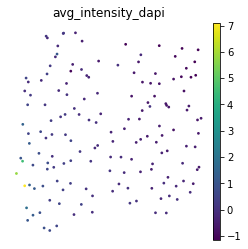

In [34]:
# Plot UMAP showing features
fig, ax = plt.subplots(figsize = (4, 4))
sc.pl.umap(adata, color = "avg_intensity_dapi", frameon = False, ax = ax,
          size = 30,
          )

fig.tight_layout()
plt.show()

In [35]:
# Find clusters
sc.tl.leiden(adata, resolution = 0.6)

running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


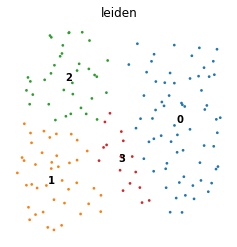

In [36]:
# Plot UMAP showing features
fig, ax = plt.subplots(figsize = (4, 4))
sc.pl.umap(adata, color = "leiden", frameon = False, ax = ax, legend_loc = "on data",
          size = 30,
          )

fig.tight_layout()
plt.show()

#### DIFFMAP

In [37]:
# Find neighbours
sc.pp.neighbors(adata, n_neighbors = 30, use_rep = 'X', method = 'gauss')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [38]:
# Run DIFFMAP
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [ 1.          0.8822965   0.7088454   0.60206664  0.5585619   0.49909317
      0.43237942  0.370051    0.29513657  0.26360038  0.25111082  0.2214084
     -0.1876797  -0.19589649 -0.19963422]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


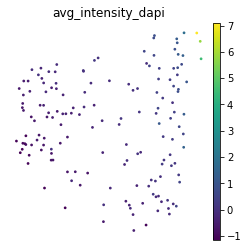

In [39]:
# Plot DIFFMAP showing features
fig, ax = plt.subplots(figsize = (4, 4))
sc.pl.diffmap(adata, color = "avg_intensity_dapi", frameon = False, ax = ax,
              size = 30, dimensions = [1,2]
             )

fig.tight_layout()
plt.show()

In [40]:
# Find clusters
sc.tl.leiden(adata, resolution = 0.6)

running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


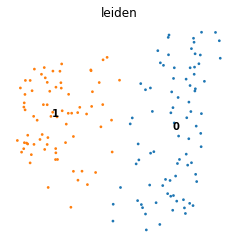

In [41]:
# Plot DIFFMAP showing features
fig, ax = plt.subplots(figsize = (4, 4))
sc.pl.diffmap(adata, color = "leiden", frameon = False, ax = ax, legend_loc = "on data",
              size = 30, dimensions = [1,2]
             )

fig.tight_layout()
plt.show()

#### Pseudotime
Choose a root cell for diffusion pseudotime:

In [45]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden']  == '0')[0]

Run diffusion pseudotime:

In [46]:
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


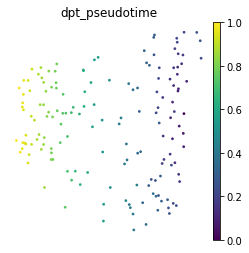

In [47]:
# Plot DIFFMAP showing features
fig, ax = plt.subplots(figsize = (4, 4))
sc.pl.diffmap(adata, color = "dpt_pseudotime", frameon = False, ax = ax,
              size = 30, dimensions = [1,2]
             )

fig.tight_layout()
plt.show()

#### Stacked violin plot

KeyError: "The key 'avg_intensity_ngn' is found in both adata.obs and adata.var_names."

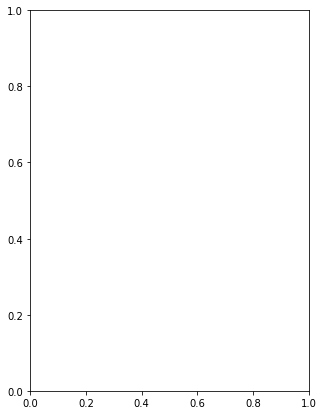

In [48]:
fig, ax = plt.subplots(figsize = (5, 7))
sc.pl.stacked_violin(adata, data_cols, groupby = 'experiment', swap_axes = True, ax = ax, dendrogram = True)
fig.tight_layout()
plt.show()

#### Pseudotime - heatmap

In [49]:
# Enter order of clusters in pseudotime
pseudotime_path = [3,4,7]

IndexError: index 3 is out of bounds for axis 0 with size 2

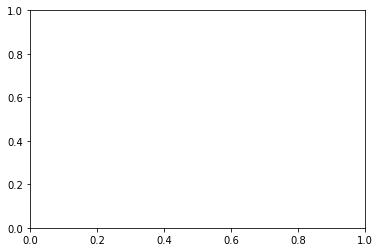

In [50]:
# Heatmap - pseudotime
sc.pl.paga_path(
    adata, 
    pseudotime_path, 
    data_cols,
    show_node_names = True,
    n_avg = 50,
    annotations = ['dpt_pseudotime'],
    show_colorbar = True,
    color_map = 'coolwarm',
    groups_key = 'leiden',
    color_maps_annotations = {'dpt_pseudotime': 'viridis'},
    title = 'Path',
    return_data = False,
    normalize_to_zero_one = True,
    show = True
)

### Save Object

In [ ]:
adata.write("/save/path/filename.hdf5")